Found 100 images in ..\WatermarkNN\data\trigger_set\pics
Found 100 images in ..\WatermarkNN\data\trigger_set\pics
✓ Evaluation datasets loaded successfully

=== Evaluating Original Watermarked MNIST Model ===


Evaluating watermark retention: 100%|██████████| 4/4 [00:00<00:00,  4.95it/s]



=== Evaluating FTLL Attacked MNIST Model ===


Evaluating watermark retention: 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]



=== Evaluating FTAL Attacked MNIST Model ===


Evaluating watermark retention: 100%|██████████| 4/4 [00:00<00:00,  5.10it/s]



=== Evaluating RTLL Attacked MNIST Model ===


Evaluating watermark retention: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s]



=== Evaluating RTAL Attacked MNIST Model ===


Evaluating watermark retention: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s]



=== Evaluating Original Watermarked FashionMNIST Model ===


Evaluating watermark retention: 100%|██████████| 4/4 [00:00<00:00,  5.06it/s]



=== Evaluating FTLL Attacked FashionMNIST Model ===


Evaluating watermark retention: 100%|██████████| 4/4 [00:00<00:00,  5.10it/s]



=== Evaluating FTAL Attacked FashionMNIST Model ===


Evaluating watermark retention: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s]



=== Evaluating RTLL Attacked FashionMNIST Model ===


Evaluating watermark retention: 100%|██████████| 4/4 [00:00<00:00,  5.12it/s]



=== Evaluating RTAL Attacked FashionMNIST Model ===


Evaluating watermark retention: 100%|██████████| 4/4 [00:00<00:00,  5.07it/s]



COMPREHENSIVE EVALUATION SUMMARY - MNIST
         Model Clean Accuracy (%) Watermark Accuracy (%) Attack Success Functionality Preserved Overall Effectiveness
Original MNIST              99.50                  12.00              ✓                       ✓                     ✓
    FTLL MNIST              99.41                  99.00              ✗                       ✓                     ✗
    FTAL MNIST              99.48                  91.00              ✗                       ✓                     ✗
    RTLL MNIST              99.21                  27.00              ✓                       ✓                     ✓
    RTAL MNIST              97.03                  10.00              ✓                       ✓                     ✓

COMPREHENSIVE EVALUATION SUMMARY - FashionMNIST
                Model Clean Accuracy (%) Watermark Accuracy (%) Attack Success Functionality Preserved Overall Effectiveness
Original FashionMNIST              93.63                   9.00             

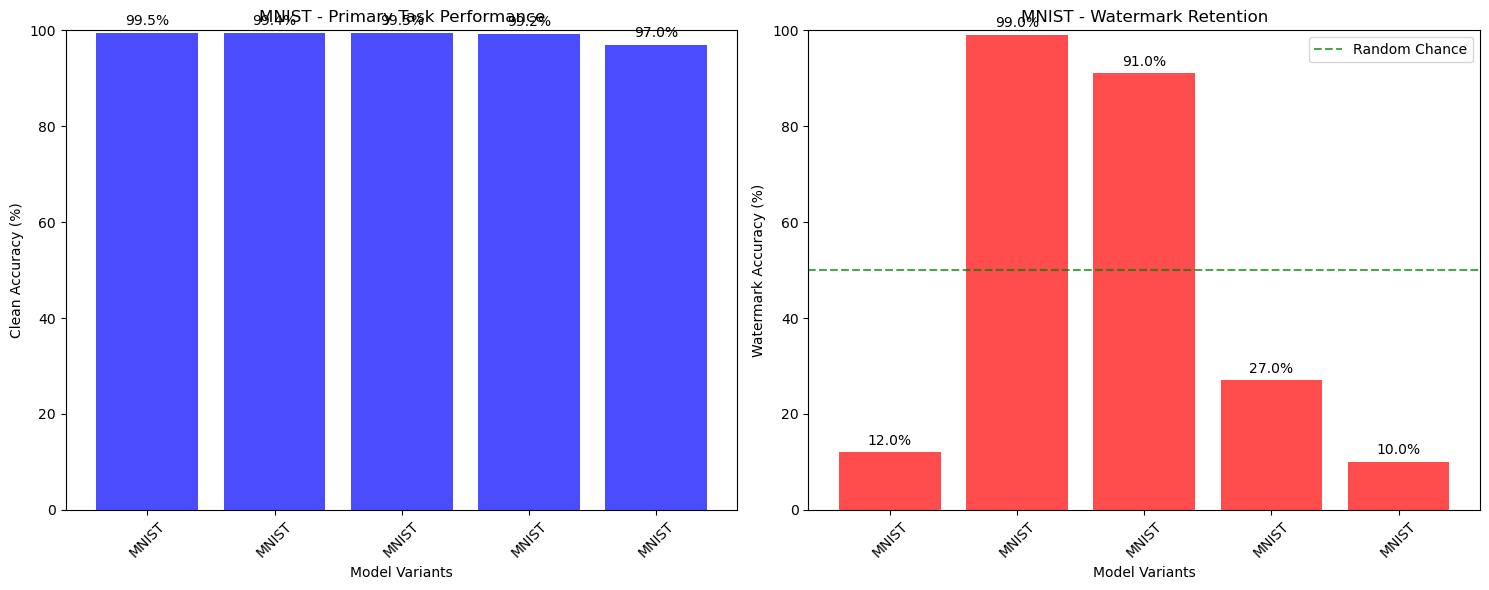


MNIST Attack Effectiveness Analysis:
Original watermark strength: 12.00%
FTLL: --87.00% watermark retention, 99.41% clean accuracy preserved
FTAL: --79.00% watermark retention, 99.48% clean accuracy preserved
RTLL: --15.00% watermark retention, 99.21% clean accuracy preserved
RTAL: -2.00% watermark retention, 97.03% clean accuracy preserved


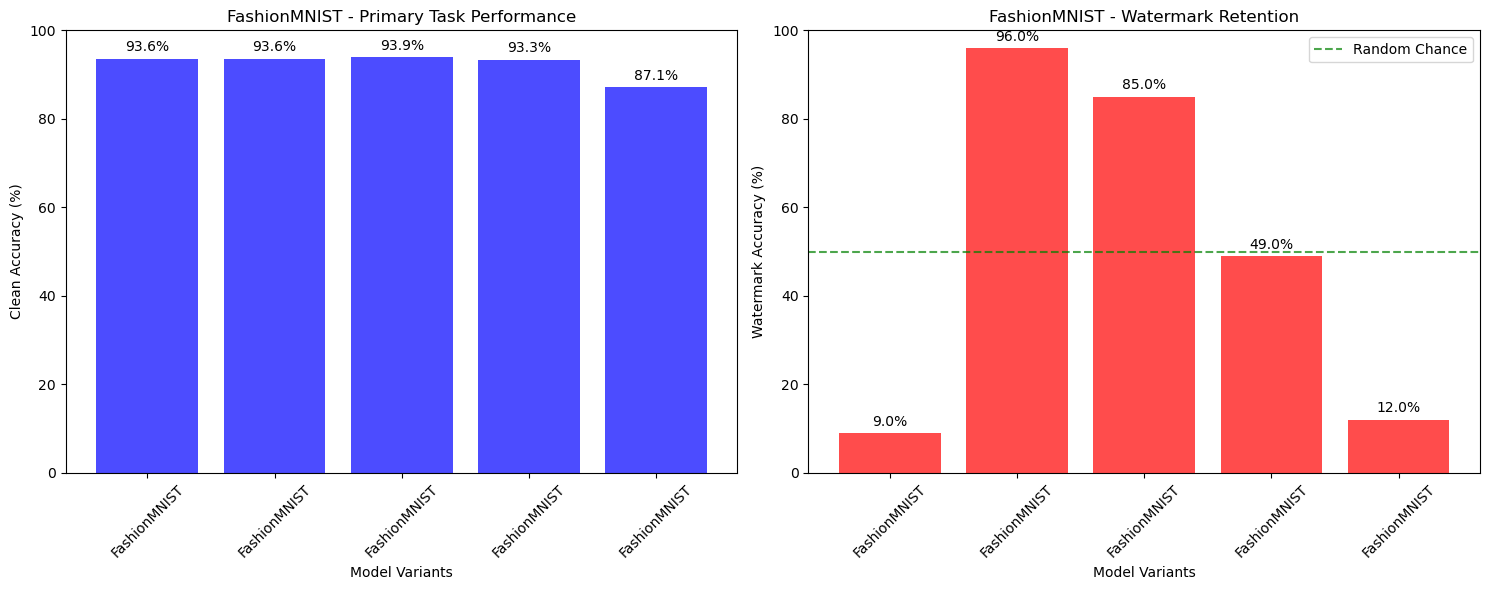


FashionMNIST Attack Effectiveness Analysis:
Original watermark strength: 9.00%
FTLL: --87.00% watermark retention, 93.58% clean accuracy preserved
FTAL: --76.00% watermark retention, 93.87% clean accuracy preserved
RTLL: --40.00% watermark retention, 93.32% clean accuracy preserved
RTAL: --3.00% watermark retention, 87.10% clean accuracy preserved

WATERMARK ROBUSTNESS EVALUATION COMPLETED
✓ Primary task performance measured for all model variants
✓ Watermark retention assessed across all attack types
✓ Attack effectiveness quantified and visualized
✓ Results saved to ./results/ directory


In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # Allow duplicate OpenMP library loading

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, FashionMNIST
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import glob

class TriggerDatasetPaper(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the trigger images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
        self.image_paths.extend(glob.glob(os.path.join(root_dir, '*.png'))) # Also find .png
        print(f"Found {len(self.image_paths)} images in {root_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        # Extract label from filename like "image_0_label_7.jpeg" -> 7
        try:
            filename = os.path.basename(img_path)
            label_str = str(int(filename.split('.')[0])%10)
            label = int(label_str)
        except (IndexError, ValueError) as e:
            raise ValueError(f"Could not parse label from filename: {img_path}. Expected format 'x.jpeg'") from e

        if self.transform:
            image = self.transform(image)

        return image, label

def evaluate_model_accuracy(model, test_dataloader, device='cuda'):
    """Evaluate model accuracy on clean test data"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_dataloader, desc="Evaluating clean accuracy"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

def evaluate_watermark_retention(model, trigger_dataset, device='cuda', batch_size=32):
    """Evaluate how well the model retains watermark associations"""
    model.eval()
    trigger_loader = DataLoader(trigger_dataset, batch_size=batch_size, shuffle=False)
    
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(trigger_loader, desc="Evaluating watermark retention"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    watermark_accuracy = 100 * correct / total
    
    return {
        'watermark_accuracy': watermark_accuracy,
        'predictions': predictions,
        'true_labels': true_labels,
        'total_samples': total
    }

def comprehensive_model_evaluation(model, clean_test_loader, trigger_dataset, 
                                 model_name="Model", device='cuda'):
    """Perform comprehensive evaluation of both primary task and watermark retention"""
    
    # Evaluate primary task performance
    clean_accuracy = evaluate_model_accuracy(model, clean_test_loader, device)
    
    # Evaluate watermark retention
    watermark_results = evaluate_watermark_retention(model, trigger_dataset, device)
    
    # Calculate attack success metrics
    attack_success = watermark_results['watermark_accuracy'] < 50.0  # Below random chance
    functionality_preserved = clean_accuracy > 80.0  # Maintains reasonable performance
    
    results = {
        'model_name': model_name,
        'clean_accuracy': clean_accuracy,
        'watermark_accuracy': watermark_results['watermark_accuracy'],
        'watermark_predictions': watermark_results['predictions'],
        'watermark_labels': watermark_results['true_labels'],
        'attack_success': attack_success,
        'functionality_preserved': functionality_preserved,
        'overall_attack_effectiveness': attack_success and functionality_preserved
    }
    
    return results

# Setup evaluation environment
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transforms (matching training pipeline)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load clean test datasets
test_mnist = MNIST(root='./data/raw/MNIST', train=False, download=True, transform=transform)
test_fashion = FashionMNIST(root='./data/raw/FashionMNIST', train=False, download=True, transform=transform)

test_loader_mnist = DataLoader(
    test_mnist, batch_size=100, shuffle=False, 
    num_workers=18, persistent_workers=True, pin_memory=True
)
test_loader_fashion = DataLoader(
    test_fashion, batch_size=100, shuffle=False, 
    num_workers=18, persistent_workers=True, pin_memory=True
)

# Load trigger sets with updated filename parsing
trigger_mnist = TriggerDatasetPaper("..\WatermarkNN\data\\trigger_set\pics", transform=transform)
trigger_fashion = TriggerDatasetPaper("..\WatermarkNN\data\\trigger_set\pics", transform=transform)

print("✓ Evaluation datasets loaded successfully")

def load_and_evaluate_models(dataset_name, clean_test_loader, trigger_dataset):
    """Load all model variants and perform comprehensive evaluation"""
    
    # Load original watermarked model
    watermarked_model = torch.load(f'./models/watermarked_{dataset_name.lower()}_model.pth', weights_only=False)
    # if dataset_name == "MNIST":
    #     watermarked_model = torch.load('./models/mnist__baseline_NO_watermark.pth', weights_only=False)
    # else:
    #     watermarked_model = torch.load('./models/fmnist__baseline_NO_watermark.pth', weights_only=False)
    
    
    watermarked_model.to(device)
    
    # Load all attacked models
    attack_types = ['ftll', 'ftal', 'rtll', 'rtal']
    
    results = []
    
    # Evaluate original watermarked model
    print(f"\n=== Evaluating Original Watermarked {dataset_name} Model ===")
    original_results = comprehensive_model_evaluation(
        watermarked_model, clean_test_loader, trigger_dataset, 
        f"Original {dataset_name}", device
    )
    watermarked_model.to('cpu')  # Free GPU memory
    results.append(original_results)
    
    # Evaluate each attacked model
    for attack_type in attack_types:
        try:
            model_path = f'./models/attacked/{dataset_name.lower()}_{attack_type}_attacked.pth'
            attacked_model = torch.load(model_path, weights_only=False)
            attacked_model.to(device)
            
            print(f"\n=== Evaluating {attack_type.upper()} Attacked {dataset_name} Model ===")
            attack_results = comprehensive_model_evaluation(
                attacked_model, clean_test_loader, trigger_dataset,
                f"{attack_type.upper()} {dataset_name}", device
            )
            results.append(attack_results)
            attacked_model.to('cpu')  # Free GPU memory
            
        except FileNotFoundError:
            print(f"Warning: {attack_type.upper()} attacked model not found for {dataset_name}")
            
    return results

# Perform comprehensive evaluation on both datasets
mnist_results = load_and_evaluate_models("MNIST", test_loader_mnist, trigger_mnist)
fashion_results = load_and_evaluate_models("FashionMNIST", test_loader_fashion, trigger_fashion)

def create_results_summary(results_list, dataset_name):
    """Create a comprehensive summary of evaluation results"""
    
    summary_data = []
    for result in results_list:
        summary_data.append({
            'Model': result['model_name'],
            'Clean Accuracy (%)': f"{result['clean_accuracy']:.2f}",
            'Watermark Accuracy (%)': f"{result['watermark_accuracy']:.2f}",
            'Attack Success': "✓" if result['attack_success'] else "✗",
            'Functionality Preserved': "✓" if result['functionality_preserved'] else "✗",
            'Overall Effectiveness': "✓" if result['overall_attack_effectiveness'] else "✗"
        })
    
    df = pd.DataFrame(summary_data)
    
    print(f"\n{'='*60}")
    print(f"COMPREHENSIVE EVALUATION SUMMARY - {dataset_name}")
    print(f"{'='*60}")
    print(df.to_string(index=False))
    
    return df

# Generate comprehensive summaries
mnist_summary = create_results_summary(mnist_results, "MNIST")
fashion_summary = create_results_summary(fashion_results, "FashionMNIST")

def analyze_attack_effectiveness(results_list, dataset_name):
    """Analyze and visualize attack effectiveness patterns"""
    
    model_names = [r['model_name'] for r in results_list]
    clean_accuracies = [r['clean_accuracy'] for r in results_list]
    watermark_accuracies = [r['watermark_accuracy'] for r in results_list]
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Clean accuracy comparison
    ax1.bar(range(len(model_names)), clean_accuracies, color='blue', alpha=0.7)
    ax1.set_xlabel('Model Variants')
    ax1.set_ylabel('Clean Accuracy (%)')
    ax1.set_title(f'{dataset_name} - Primary Task Performance')
    ax1.set_xticks(range(len(model_names)))
    ax1.set_xticklabels([name.split()[-1] for name in model_names], rotation=45)
    ax1.set_ylim(0, 100)
    
    # Add accuracy values on bars
    for i, v in enumerate(clean_accuracies):
        ax1.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')
    
    # Watermark retention comparison
    ax2.bar(range(len(model_names)), watermark_accuracies, color='red', alpha=0.7)
    ax2.set_xlabel('Model Variants')
    ax2.set_ylabel('Watermark Accuracy (%)')
    ax2.set_title(f'{dataset_name} - Watermark Retention')
    ax2.set_xticks(range(len(model_names)))
    ax2.set_xticklabels([name.split()[-1] for name in model_names], rotation=45)
    ax2.set_ylim(0, 100)
    ax2.axhline(y=50, color='green', linestyle='--', alpha=0.7, label='Random Chance')
    ax2.legend()
    
    # Add accuracy values on bars
    for i, v in enumerate(watermark_accuracies):
        ax2.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(f'./results/{dataset_name.lower()}_attack_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Statistical analysis
    original_watermark_acc = results_list[0]['watermark_accuracy']
    
    print(f"\n{dataset_name} Attack Effectiveness Analysis:")
    print(f"Original watermark strength: {original_watermark_acc:.2f}%")
    
    for i, result in enumerate(results_list[1:], 1):
        attack_name = result['model_name'].split()[0]
        watermark_reduction = original_watermark_acc - result['watermark_accuracy']
        clean_preservation = result['clean_accuracy']
        
        print(f"{attack_name}: -{watermark_reduction:.2f}% watermark retention, "
              f"{clean_preservation:.2f}% clean accuracy preserved")

# Create results directory
os.makedirs('./results', exist_ok=True)

# Perform detailed analysis
analyze_attack_effectiveness(mnist_results, "MNIST")
analyze_attack_effectiveness(fashion_results, "FashionMNIST")

print("\n" + "="*80)
print("WATERMARK ROBUSTNESS EVALUATION COMPLETED")
print("="*80)
print("✓ Primary task performance measured for all model variants")
print("✓ Watermark retention assessed across all attack types")
print("✓ Attack effectiveness quantified and visualized")
print("✓ Results saved to ./results/ directory")
